In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [2]:
H, W = 224, 224
BATCH_SIZE = 64

In [3]:
image_paths = []
image_labels = []
glioma_count = menin_count = tumor_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'brain_glioma' in filename:
            image_labels.append(0)
            glioma_count += 1
        elif 'brain_menin' in filename:
            image_labels.append(1)
            menin_count += 1
        else:
            image_labels.append(2)
            tumor_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')

print("Image count:", len(image_paths))
print("Brain glioma count:", glioma_count)
print("Brain menin count:", menin_count)
print("Brain tumor count:", tumor_count)

print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_1928.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_1420.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_3727.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_0759.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_4253.jpg'] 

[1, 2, 0, 2, 2] 

Image count: 15000
Brain glioma count: 5000
Brain menin count: 5000
Brain tumor count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 80%, 10%, 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print('Train size:', len(train_paths))
print('val size:', len(val_paths))
print('Test size:', len(test_paths))

Train size: 10500
val size: 2250
Test size: 2250


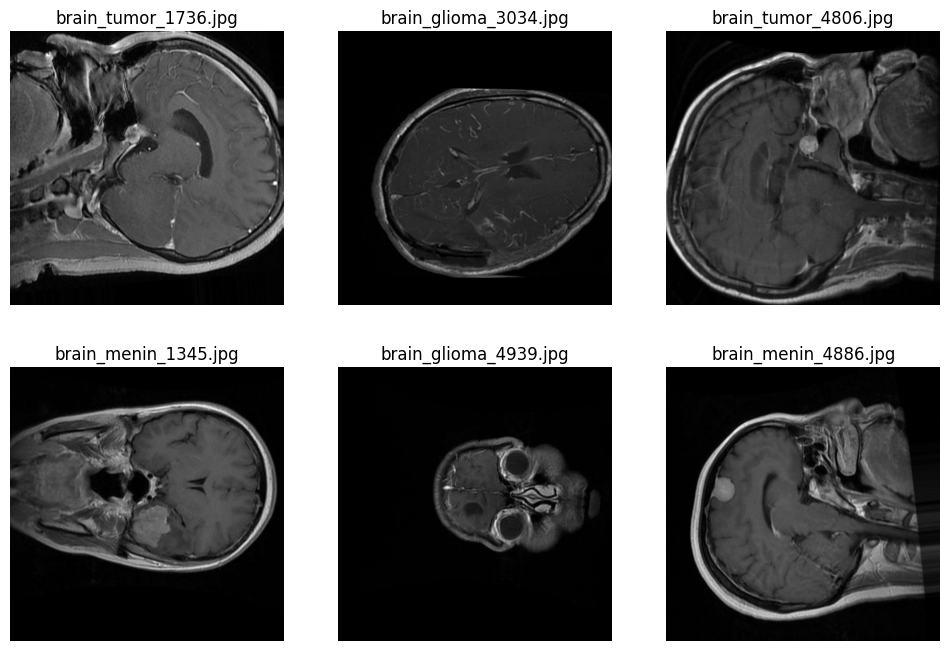

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 10500/10500 [01:39<00:00, 105.52it/s]

Mean: tensor([0.1539, 0.1539, 0.1539])
Std: tensor([0.1640, 0.1640, 0.1640])


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 3) 

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)


    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 1 Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")
        
print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 



--- Training  ---


Epoch 1/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:27<00:00,  1.33it/s, loss=0.254]


Phase 1 Epoch 1/25 | Train Loss: 0.4527 Acc: 0.8296 | Val Loss: 0.3325 Acc: 0.8831
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8831


Epoch 2/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s, loss=0.356]


Phase 1 Epoch 2/25 | Train Loss: 0.3134 Acc: 0.8857 | Val Loss: 0.2985 Acc: 0.9040
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9040


Epoch 3/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s, loss=0.273]


Phase 1 Epoch 3/25 | Train Loss: 0.2855 Acc: 0.8971 | Val Loss: 0.2666 Acc: 0.9062
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9062


Epoch 4/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s, loss=0.148]


Phase 1 Epoch 4/25 | Train Loss: 0.2593 Acc: 0.9042 | Val Loss: 0.2398 Acc: 0.9178
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9178


Epoch 5/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s, loss=0.206]


Phase 1 Epoch 5/25 | Train Loss: 0.2538 Acc: 0.9047 | Val Loss: 0.2352 Acc: 0.9187
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9187


Epoch 6/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:26<00:00,  1.35it/s, loss=0.114]


Phase 1 Epoch 6/25 | Train Loss: 0.2429 Acc: 0.9081 | Val Loss: 0.2382 Acc: 0.9120


Epoch 7/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:30<00:00,  1.17it/s, loss=0.172]


Phase 1 Epoch 7/25 | Train Loss: 0.2445 Acc: 0.9069 | Val Loss: 0.2210 Acc: 0.9231
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9231


Epoch 8/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s, loss=0.26] 


Phase 1 Epoch 8/25 | Train Loss: 0.2368 Acc: 0.9124 | Val Loss: 0.2513 Acc: 0.9004


Epoch 9/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s, loss=0.616]


Phase 1 Epoch 9/25 | Train Loss: 0.2331 Acc: 0.9145 | Val Loss: 0.2209 Acc: 0.9164


Epoch 10/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s, loss=0.407] 


Phase 1 Epoch 10/25 | Train Loss: 0.2266 Acc: 0.9153 | Val Loss: 0.1983 Acc: 0.9276
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9276


Epoch 11/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=0.269]


Phase 1 Epoch 11/25 | Train Loss: 0.2233 Acc: 0.9144 | Val Loss: 0.2355 Acc: 0.9049


Epoch 12/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s, loss=0.131]


Phase 1 Epoch 12/25 | Train Loss: 0.2194 Acc: 0.9190 | Val Loss: 0.2040 Acc: 0.9253


Epoch 13/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s, loss=0.0485]


Phase 1 Epoch 13/25 | Train Loss: 0.2218 Acc: 0.9141 | Val Loss: 0.1883 Acc: 0.9316
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9316


Epoch 14/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s, loss=0.179]


Phase 1 Epoch 14/25 | Train Loss: 0.2160 Acc: 0.9178 | Val Loss: 0.1918 Acc: 0.9302


Epoch 15/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s, loss=0.0335]


Phase 1 Epoch 15/25 | Train Loss: 0.2158 Acc: 0.9195 | Val Loss: 0.1882 Acc: 0.9333
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9333


Epoch 16/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s, loss=0.0752]


Phase 1 Epoch 16/25 | Train Loss: 0.2079 Acc: 0.9238 | Val Loss: 0.1870 Acc: 0.9307


Epoch 17/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s, loss=0.0491]


Phase 1 Epoch 17/25 | Train Loss: 0.2096 Acc: 0.9208 | Val Loss: 0.1867 Acc: 0.9316


Epoch 18/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s, loss=0.21] 


Phase 1 Epoch 18/25 | Train Loss: 0.2007 Acc: 0.9246 | Val Loss: 0.2086 Acc: 0.9222


Epoch 19/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s, loss=0.026]


Phase 1 Epoch 19/25 | Train Loss: 0.2102 Acc: 0.9223 | Val Loss: 0.2312 Acc: 0.9049


Epoch 20/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s, loss=0.547] 


Phase 1 Epoch 20/25 | Train Loss: 0.2145 Acc: 0.9185 | Val Loss: 0.1935 Acc: 0.9280


Epoch 21/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s, loss=0.161] 


Phase 1 Epoch 21/25 | Train Loss: 0.1968 Acc: 0.9249 | Val Loss: 0.1793 Acc: 0.9289


Epoch 22/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s, loss=0.573] 


Phase 1 Epoch 22/25 | Train Loss: 0.2169 Acc: 0.9165 | Val Loss: 0.1734 Acc: 0.9382
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.9382


Epoch 23/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s, loss=0.0156]


Phase 1 Epoch 23/25 | Train Loss: 0.2081 Acc: 0.9202 | Val Loss: 0.1832 Acc: 0.9302


Epoch 24/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s, loss=0.126] 


Phase 1 Epoch 24/25 | Train Loss: 0.1911 Acc: 0.9296 | Val Loss: 0.1813 Acc: 0.9302


Epoch 25/25 [Phase 1 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=0.328] 

Phase 1 Epoch 25/25 | Train Loss: 0.1903 Acc: 0.9291 | Val Loss: 0.1807 Acc: 0.9293
finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   

model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")


for param in model.parameters():
    param.requires_grad = True


optimizer = optim.Adam(model.parameters(), lr=1e-5) 

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 2 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.9382


Epoch 1/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s, loss=0.00543]


Phase 2 Epoch 1/20 | Train Loss: 0.1208 Acc: 0.9551 | Val Loss: 0.0803 Acc: 0.9693
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9693


Epoch 2/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=0.0165]


Phase 2 Epoch 2/20 | Train Loss: 0.0619 Acc: 0.9790 | Val Loss: 0.0510 Acc: 0.9840
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9840


Epoch 3/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s, loss=0.161]  


Phase 2 Epoch 3/20 | Train Loss: 0.0431 Acc: 0.9862 | Val Loss: 0.0408 Acc: 0.9876
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9876


Epoch 4/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.07it/s, loss=0.00177]


Phase 2 Epoch 4/20 | Train Loss: 0.0310 Acc: 0.9895 | Val Loss: 0.0249 Acc: 0.9938
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9938


Epoch 5/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s, loss=0.00174]


Phase 2 Epoch 5/20 | Train Loss: 0.0202 Acc: 0.9935 | Val Loss: 0.0236 Acc: 0.9902


Epoch 6/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s, loss=0.00123] 


Phase 2 Epoch 6/20 | Train Loss: 0.0177 Acc: 0.9938 | Val Loss: 0.0182 Acc: 0.9933


Epoch 7/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s, loss=0.00216]


Phase 2 Epoch 7/20 | Train Loss: 0.0179 Acc: 0.9940 | Val Loss: 0.0155 Acc: 0.9956
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9956


Epoch 8/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=0.0011]  


Phase 2 Epoch 8/20 | Train Loss: 0.0190 Acc: 0.9941 | Val Loss: 0.0186 Acc: 0.9924


Epoch 9/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s, loss=0.000117]


Phase 2 Epoch 9/20 | Train Loss: 0.0109 Acc: 0.9965 | Val Loss: 0.0131 Acc: 0.9951


Epoch 10/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=8.28e-5] 


Phase 2 Epoch 10/20 | Train Loss: 0.0062 Acc: 0.9979 | Val Loss: 0.0103 Acc: 0.9960
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9960


Epoch 11/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s, loss=0.000145]


Phase 2 Epoch 11/20 | Train Loss: 0.0079 Acc: 0.9971 | Val Loss: 0.0099 Acc: 0.9956


Epoch 12/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s, loss=0.00167] 


Phase 2 Epoch 12/20 | Train Loss: 0.0072 Acc: 0.9977 | Val Loss: 0.0133 Acc: 0.9951


Epoch 13/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s, loss=0.00114] 


Phase 2 Epoch 13/20 | Train Loss: 0.0088 Acc: 0.9972 | Val Loss: 0.0112 Acc: 0.9947


Epoch 14/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s, loss=0.000241]


Phase 2 Epoch 14/20 | Train Loss: 0.0070 Acc: 0.9978 | Val Loss: 0.0069 Acc: 0.9982
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9982


Epoch 15/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s, loss=0.0219]  


Phase 2 Epoch 15/20 | Train Loss: 0.0046 Acc: 0.9987 | Val Loss: 0.0048 Acc: 0.9982


Epoch 16/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s, loss=0.0138]  


Phase 2 Epoch 16/20 | Train Loss: 0.0026 Acc: 0.9994 | Val Loss: 0.0050 Acc: 0.9987
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9987


Epoch 17/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s, loss=0.000138]


Phase 2 Epoch 17/20 | Train Loss: 0.0032 Acc: 0.9990 | Val Loss: 0.0053 Acc: 0.9982


Epoch 18/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s, loss=0.000522]


Phase 2 Epoch 18/20 | Train Loss: 0.0051 Acc: 0.9990 | Val Loss: 0.0059 Acc: 0.9982


Epoch 19/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s, loss=0.000608]


Phase 2 Epoch 19/20 | Train Loss: 0.0055 Acc: 0.9984 | Val Loss: 0.0051 Acc: 0.9991
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9991


Epoch 20/20 [Phase 2 Val]: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s, loss=0.0052]  

Phase 2 Epoch 20/20 | Train Loss: 0.0072 Acc: 0.9974 | Val Loss: 0.0069 Acc: 0.9978
 Fine-tuning finished.


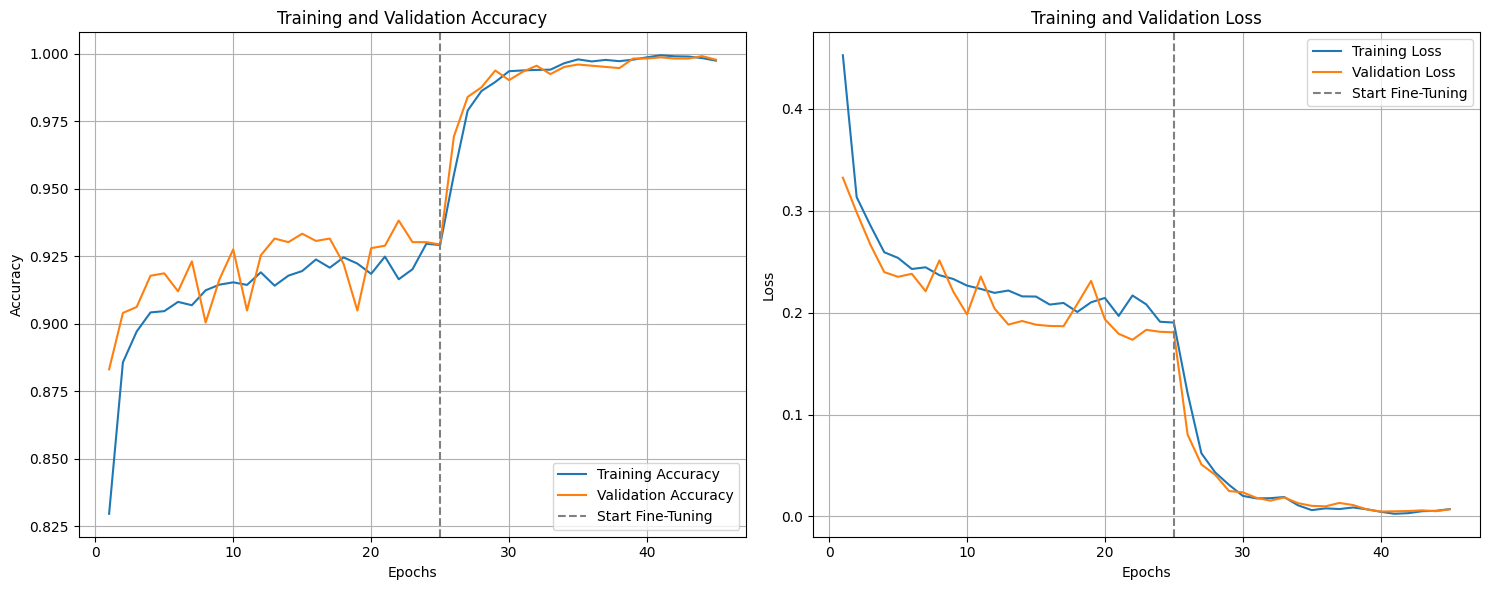

In [12]:
# ---  Learning Curve ---
def plot_learning_curves(history, phase1_epochs):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    

    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(history, phase1_epochs=EPOCH)

In [13]:
from torch.utils.data import ConcatDataset, DataLoader

full_train_dataset = ConcatDataset([train_dataset, val_dataset])

full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(best_model_path))

history_phase3 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [], 
    'val_acc': []
}

REFINE_EPOCHS = 20 
optimizer = optim.Adam(model.parameters(), lr=1e-5) 
criterion = nn.CrossEntropyLoss()



for epoch in range(REFINE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    pbar = tqdm(full_train_loader, desc=f"Epoch {epoch+1}/{REFINE_EPOCHS} [Train]")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        pbar.set_postfix({'loss': loss.item()})
        
    epoch_train_loss = train_loss / len(full_train_dataset)
    epoch_train_acc = (train_corrects.double() / len(full_train_dataset)).item()


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    epoch_val_loss = val_loss / len(test_dataset)
    epoch_val_acc = (val_corrects.double() / len(test_dataset)).item()


    history_phase3['train_loss'].append(epoch_train_loss)
    history_phase3['train_acc'].append(epoch_train_acc)
    history_phase3['val_loss'].append(epoch_val_loss)
    history_phase3['val_acc'].append(epoch_val_acc)

    print(f"   Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_val_acc:.4f}")


final_model_path = "final_refined_model.pth"
torch.save(model.state_dict(), final_model_path)

Epoch 1/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=4.22e-6] 


   Train Acc: 0.9982 | Test Acc: 0.9991


Epoch 2/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00202] 


   Train Acc: 0.9994 | Test Acc: 0.9987


Epoch 3/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00414] 


   Train Acc: 0.9984 | Test Acc: 0.9991


Epoch 4/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00141] 


   Train Acc: 0.9994 | Test Acc: 0.9991


Epoch 5/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.231]   


   Train Acc: 0.9988 | Test Acc: 0.9991


Epoch 6/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=7.96e-5] 


   Train Acc: 0.9992 | Test Acc: 1.0000


Epoch 7/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=2.32e-6] 


   Train Acc: 0.9995 | Test Acc: 1.0000


Epoch 8/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00219] 


   Train Acc: 0.9999 | Test Acc: 1.0000


Epoch 9/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00189] 


   Train Acc: 0.9999 | Test Acc: 1.0000


Epoch 10/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=0.000696]


   Train Acc: 0.9989 | Test Acc: 0.9978


Epoch 11/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.000557]


   Train Acc: 0.9994 | Test Acc: 0.9987


Epoch 12/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=0.000183]


   Train Acc: 0.9995 | Test Acc: 1.0000


Epoch 13/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.405]   


   Train Acc: 0.9996 | Test Acc: 0.9987


Epoch 14/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.00136] 


   Train Acc: 0.9987 | Test Acc: 0.9978


Epoch 15/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=7.54e-5] 


   Train Acc: 0.9991 | Test Acc: 1.0000


Epoch 16/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.000329]


   Train Acc: 0.9995 | Test Acc: 0.9969


Epoch 17/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=0.00134] 


   Train Acc: 0.9995 | Test Acc: 0.9996


Epoch 18/20 [Train]: 100%|██████████| 200/200 [02:24<00:00,  1.38it/s, loss=0.00283] 


   Train Acc: 0.9998 | Test Acc: 0.9991


Epoch 19/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=0.165]   


   Train Acc: 0.9998 | Test Acc: 0.9996


Epoch 20/20 [Train]: 100%|██████████| 200/200 [02:25<00:00,  1.38it/s, loss=5.11e-8] 


   Train Acc: 0.9986 | Test Acc: 0.9991


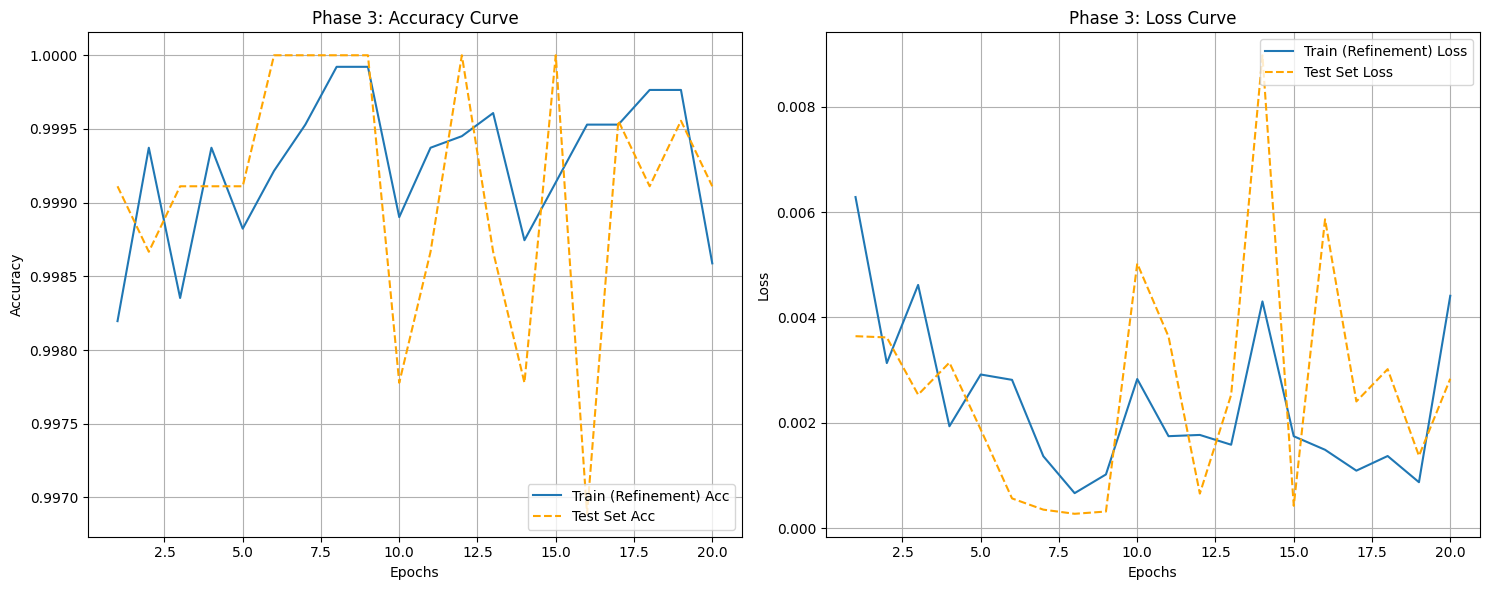

In [14]:
def plot_phase3_curves(history):
    acc = history['train_acc']
    val_acc = history['val_acc'] 
    loss = history['train_loss']
    val_loss = history['val_loss'] 
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train (Refinement) Acc')
    plt.plot(epochs_range, val_acc, label='Test Set Acc', color='orange', linestyle='--')
    plt.title('Phase 3: Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train (Refinement) Loss')
    plt.plot(epochs_range, val_loss, label='Test Set Loss', color='orange', linestyle='--')
    plt.title('Phase 3: Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 執行畫圖
plot_phase3_curves(history_phase3)


--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]



 Final Results (Brain Cancer)
Accuracy  : 0.9991
Precision : 0.9991
Recall    : 0.9991
F1 Score  : 0.9991
------------------------------

 Report 
              precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       750
  Meningioma       1.00      1.00      1.00       750
       Tumor       1.00      1.00      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



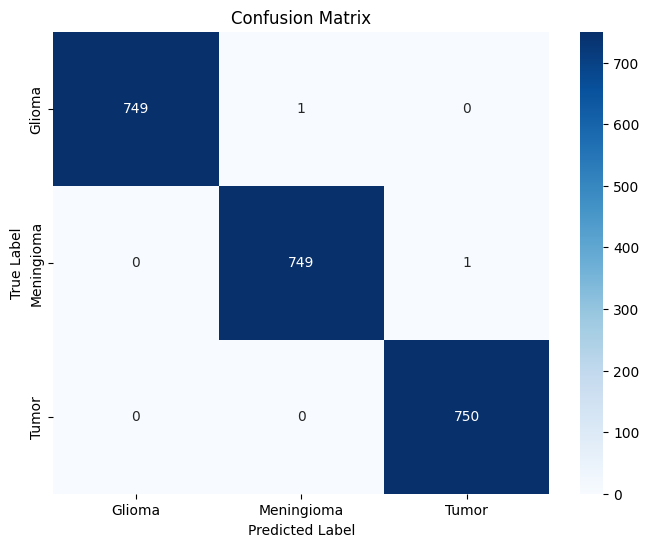

In [15]:
print("\n--- Final Testing & Metrics Calculation ---")


model.load_state_dict(torch.load(final_model_path))
model.eval()
model.to(device)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "="*30)
print(f" Final Results (Brain Cancer)")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


target_names = ['Glioma', 'Meningioma', 'Tumor']
print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=target_names))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()